# Aligning clusters using linear programming

Gilles Louppe -- [@glouppe](https://twitter.com/glouppe)

Last changes on June 25, 2015.

## Motivation

Because of changes in data (addition, removal or updates of samples) or changes of parameters, clusters produced by a clustering procedure may change (either slightly or significantly) from one execution at time $t$ to another at $t+1$. In this context, one may be interested in matching the clusters found at $t$ with the one newly found  $t+1$. In particular, this problem gets difficult because 
- clusters at $t$ may be merged or scattered into one (or several) other clusters at $t+1$ ;
- clusters at time $t$ may disappear at $t+1$ ;
- clusters at time $t+1$ may be newly created.

## Problem statement

Let us assume a set ${\cal L}_a = \{ x_i | i = 0, ..., N_a-1 \}$ and a [partition](https://en.wikipedia.org/wiki/Partition_of_a_set) $P_a = \{ S_{a,0}, ..., S_{a,{K_a-1}} \}$ of ${\cal L}_a$ into $K_a$ clusters. Let us also assume a superset ${\cal L}_b = \{ x_i | i = 0, ..., N_b-1 \} \supseteq {\cal L}_a$ and a partition $P_b = \{ S_{b,0}, ..., S_{b,{K_b-1}} \}$ of ${\cal L}_b$ into $K_b$ clusters. Our objective is to find a (one-sided) matching of $P_b$ with $P_a$. 

## Example

Let us consider two consecutive executions of the KMeans algorithm when
- new samples are added to a dataset (i.e., $N_b \geq N_a$) and
- parameters of the KMeans are changed from one execution to the other.

In [2]:
import numpy as np

# Generate random data
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

N_a = 100
N_b = 120 # Let's add 20 samples

X, _ = make_blobs(n_samples=N_b, centers=3, cluster_std=1.0, random_state=0)
X = StandardScaler().fit_transform(X)

X_a = X[:N_a]
X_b = X[:N_b]

# Cluster X_a and X_b
from sklearn.cluster import KMeans

labels_a = KMeans(n_clusters=3, n_init=1, random_state=0).fit(X_a).labels_
labels_b = KMeans(n_clusters=4, n_init=1, random_state=1).fit(X_b).labels_

K_a = len(np.unique(labels_a))
K_b = len(np.unique(labels_b))

indices = np.arange(len(X_a))
P_a = [set(indices[labels_a == l]) for l in np.unique(labels_a)]

indices = np.arange(len(X_b))
P_b = [set(indices[labels_b == l]) for l in np.unique(labels_b)]

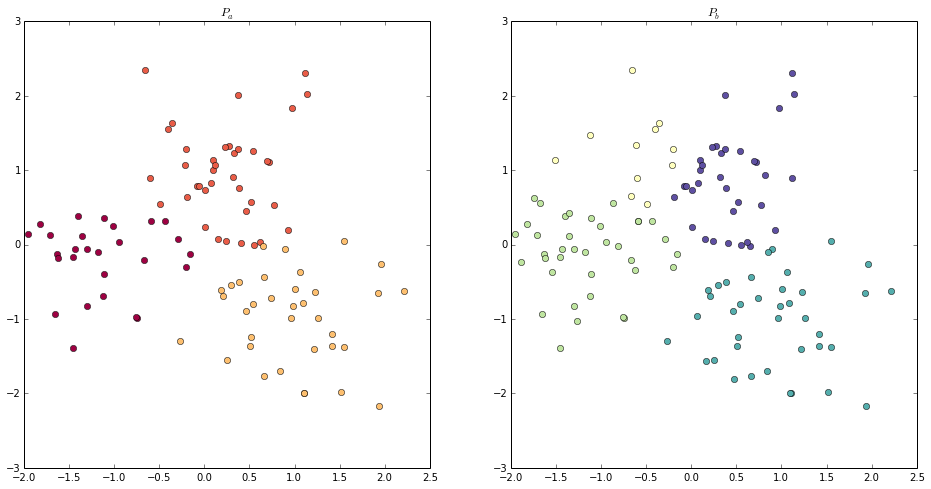

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, K_a + K_b))

# Plot P_a
plt.subplot(121)
for l, col in zip(range(K_a), colors[:K_a]):
    samples = labels_a == l
    plt.plot(X_a[samples, 0], X_a[samples, 1], 'o', c=col)
plt.title("$P_a$")

# Plot P_b
plt.subplot(122)
for l, col in zip(range(K_b), colors[K_a:]):
    samples = labels_b == l
    plt.plot(X_b[samples, 0], X_b[samples, 1], 'o', c=col)
plt.title("$P_b$")

plt.show()

In this example, our goal is therefore to find to which clusters in $P_a$ the clusters in $P_b$ can be best matched, with respect to some definition of _"best"_.

Intuitively, a natural solution would be to say that:
- the light green cluster in $P_b$ matches the purple cluster in $P_a$,
- the navy cluster in $P_b$ matches the red cluster in $P_a$,
- the turquoise cluster in $P_b$ matches the orange cluster in $P_a$,
- the yellow cluster in $P_b$ is new.

Let us see how this can be found programmaticaly.

## The assignment problem

The cluster alignment we are trying to achieve can be reduced to an instance of the [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem), which itself reduces to the problem of finding a minimum weight matching in a weighted bipartite graph.

**Assignment problem:** There are a number of agents and a number of tasks. Any agent can be assigned to perform any task, incurring some cost that may vary depending on the agent-task assignment. It is required to perform all tasks by assigning exactly one agent to each task and exactly one task to each agent in such a way that the total cost of the assignment is minimized.

In our setting, clusters in $P_a$ would then correspond to agents while clusters in $P_b$ would correspond to tasks. In this definition however, all clusters in $P_a$ would need be matched to one and only one cluster in $P_b$, which prevents us from creating new or deleting clusters. To accomodate for this, we instead consider the  one-sided variant 
- where agents (clusters in $P_a$) need to be matched to zero or one task (to zero or one cluster in $P_b$), thereby allowing clusters in $P_a$ to be deleted;
- where agents (clusters in $P_a$) are complemented with $K_b$ virtual agents ($K_b$ new empty clusters) and where tasks (clusters in $P_b$) need to be matched to one and only agent (possibly virtual), thereby allowing clusters in $P_b$ to be created.

In [4]:
# Append virtual agents
for j in range(K_b):
    P_a.append(set())

For our problem above, in terms of bipartite graph, we would therefore look for the following matching:

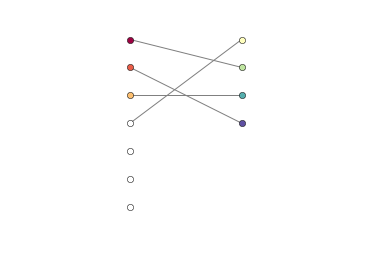

In [5]:
plt.plot([0, 1], [K_a+K_b, K_a+K_b-1], c="gray")
plt.plot([0, 1], [K_a+K_b-1, K_a+K_b-3], c="gray")
plt.plot([0, 1], [K_a+K_b-2, K_a+K_b-2], c="gray")
plt.plot([0, 1], [K_a+K_b-3, K_a+K_b], c="gray")

for l, col in zip(range(K_a), colors[:K_a]):
    plt.plot(0, K_a+K_b-l, 'o', c=col)
for l in range(K_a, K_a+K_b):
    plt.plot(0, K_a+K_b-l, 'o', c="white")
for l, col in zip(range(K_b), colors[K_a:]):
    plt.plot(1, K_a+K_b-l, 'o', c=col)

plt.xlim(-1, 2)
plt.ylim(0, K_a + K_b + 1)
plt.axis("off")
plt.show()

where the white circles correspond to virtual agents (empty clusters).

## Linear programming

Assuming edges in the bipartite graph are denoted $x_{ij}$ (for $i = 0, ..., K_a+K_b-1$ and $j = 0, ..., K_b-1$), the problem of finding the minimum weight matching can be formulated in terms of the following linear program:

$$
\min \sum_{ij} c_{ij} x_{ij} \\
\textit{subject to} \\
\text{(1) } \sum_{j} x_{ij} \leq 1, \text{for } i = 0, ..., K_a+K_b-1 \\
\text{(2) } \sum_{i} x_{ij} = 1, \text{for } j = 0, ..., K_b \\
\text{(3) } x_{ij} \geq 0
$$

where $c_{ij}$ is the cost associated to $x_{ij}$.

The first set of constraints indicate that clusters in $P_a$ may be matched to a most one cluster in $P_b$, while the second set of constraints indicate that clusters in $P_b$ need to be matched to one and only cluster in $P_a$.

Let us now consider $c_{ij}$, that is the cost (or the negative profit) of matching $C_{a,i}$ with $C_{b,j}$. An intuitive choice is to consider the negative size of the intersection between the two sets, thereby looking for a matching which maximises the overall overlap between the matched clusters.

In [6]:
def cost_intersection(P_a, P_b):
    cost = np.zeros((len(P_a), len(P_b)))

    for i, s_i in enumerate(P_a):
        for j, s_j in enumerate(P_b):
            cost[i, j] = -len(s_i.intersection(s_j)) 

    return cost

cost = cost_intersection(P_a, P_b)
print cost

[[  0. -27.   0.   0.]
 [ -7.   0.   0. -31.]
 [  0.   0. -34.  -1.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]


Using `scipy.optimize.linprog` for solving our linear program using the [simplex method](https://en.wikipedia.org/wiki/Simplex_algorithm), one can finally find the best alignment between our clusters:

In [7]:
def solve(K_a, K_b, cost):
    n_edges = (K_a + K_b) * K_b

    # Each agent may be assigned to at most one task
    A_ub = np.zeros((K_a + K_b, n_edges))
    for i in range(K_a + K_b):
        A_ub[i, i*K_b:(i+1)*K_b] = 1.0
    b_ub = np.ones(K_a + K_b)

    # Each task has to be assigned to exactly one agent
    A_eq = np.zeros((K_b, n_edges))
    for j in range(K_b):
        A_eq[j, j::K_b] = 1.0
    b_eq = np.ones(K_b)

    # Solve
    from scipy.optimize import linprog
    c = cost.ravel()
    r = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, options={"maxiter": 5000})
    return r

r = solve(K_a, K_b, cost)
print r

  status: 0
   slack: array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.])
 success: True
     fun: -92.0
       x: array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])
 message: 'Optimization terminated successfully.'
     nit: 17


Values set to `1` in the solution vector `r.x` indicate the edges in the matching, which can be read as follows:

In [8]:
def print_solution(r, K_a, K_b):
    for i in range(K_a + K_b):
        for j in range(K_b):
            if r.x[i*K_b+j] == 1:
                if i < K_a:
                    print "match for cluster", i, "in P_a and cluster", j, "in P_b"
                else:
                    print "cluster", j, "in P_b created"
                break
        else:
            print "cluster", i, "in P_a deleted"
            
print_solution(r, K_a, K_b)

match for cluster 0 in P_a and cluster 1 in P_b
match for cluster 1 in P_a and cluster 3 in P_b
match for cluster 2 in P_a and cluster 2 in P_b
cluster 0 in P_b created
cluster 4 in P_a deleted
cluster 5 in P_a deleted
cluster 6 in P_a deleted


... and indeed it works!

## Tuning the cost function

When the intersection between candidate matched clusters is empty, the solution found by the simplex method may not be as appropriate as we would want, as the following example illustrates:

In [9]:
K_a = 2
K_b = 2
P_a = [set([1]), set([2, 3, 4, 5]), set([]), set([])]
P_b = [set([2]), set([1, 3, 4, 5])]
print "P_a =", P_a
print "P_b =", P_b
print 

cost = cost_intersection(P_a, P_b)
r = solve(K_a, K_b, cost)
print r
print

print_solution(r, K_a, K_b)

P_a = [set([1]), set([2, 3, 4, 5]), set([]), set([])]
P_b = [set([2]), set([1, 3, 4, 5])]

  status: 0
   slack: array([ 0.,  0.,  1.,  1.])
 success: True
     fun: -3.0
       x: array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
     nit: 6

match for cluster 0 in P_a and cluster 0 in P_b
match for cluster 1 in P_a and cluster 1 in P_b
cluster 2 in P_a deleted
cluster 3 in P_a deleted


In this case, cluster 1 in $P_a$ (`[2, 3, 4, 5]`) is correctly matched with cluster 1 in $P_b$ (`[1, 3, 4, 5]`). However cluster 0 in $P_a$ (`[1]`) is matched with cluster 0 in $P_b$ (`[2]`). While this solution is  optimal with respect to the cost function we defined, we would rather favor cluster 0 in $P_a$ (`[1]`)  to be marked as deleted and cluster 0 in $P_b$ (`[2]`) to be marked as created. To achieve this, the cost function can be rewritten in the following way, so that the size of the symmetric difference is minimized when the intersection is empty:

In [10]:
def cost_intersection_symmetric_diff(P_a, P_b):
    cost = np.zeros((len(P_a), len(P_b)))

    for i, s_i in enumerate(P_a):
        for j, s_j in enumerate(P_b):
            cost[i, j] = -len(s_i.intersection(s_j)) -1. / (1 + len(s_i.symmetric_difference(s_j)))

    return cost

In [11]:
K_a = 2
K_b = 2
P_a = [set([1]), set([2, 3, 4, 5]), set([]), set([])]
P_b = [set([2]), set([1, 3, 4, 5])]
print "P_a =", P_a
print "P_b =", P_b
print

cost = cost_intersection_symmetric_diff(P_a, P_b)
r = solve(K_a, K_b, cost)
print r
print 

print_solution(r, K_a, K_b)

P_a = [set([1]), set([2, 3, 4, 5]), set([]), set([])]
P_b = [set([2]), set([1, 3, 4, 5])]

  status: 0
   slack: array([ 1.,  0.,  0.,  1.])
 success: True
     fun: -3.8333333333333339
       x: array([ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
     nit: 6

cluster 0 in P_a deleted
match for cluster 1 in P_a and cluster 1 in P_b
cluster 0 in P_b created
cluster 3 in P_a deleted
